In [ ]:
import pandas as pd
import numpy as np
import os
import copy
from sklearn.preprocessing import minmax_scale
from scipy.stats import zscore
import torch


In [ ]:
fpkm_replicates = pd.read_csv("FPKM_replicates.csv")
fpkm_replicates.head()
fpkm_replicates.shape

(33560, 48)

#Gene Data Filtering

In [ ]:
C_group = fpkm_replicates[["tracking_id"]+[col for col in fpkm_replicates.columns if "C" in col]]
S_group = fpkm_replicates[["tracking_id"]+[col for col in fpkm_replicates.columns if "S" in col]]
WT_group = fpkm_replicates[["tracking_id"]+[col for col in fpkm_replicates.columns if "WT" in col]]


def filter_data(df, min_num_of_non_zero=2):
    mask = df.apply(lambda x: x[x != 0].count(), axis=1) >= min_num_of_non_zero
    anti_mask = df.apply(lambda x: x[x != 0].count(), axis=1) < min_num_of_non_zero
    filtered = df[mask]
    removed = df[anti_mask]

    return filtered, removed

filtered_C, removed_C = filter_data(C_group)
filtered_S, removed_S = filter_data(S_group)
filtered_WT, removed_WT = filter_data(WT_group)

In [ ]:
# Get the union of filtered genes across all plant lines and removed genes

# list(set(([1,2,3,4]+[2,3,5]+[4,5,6])))  -> [1, 2, 3, 4, 5, 6]

filtered_genes_union = list(set( list(filtered_C["tracking_id"]) + list(filtered_S["tracking_id"]) + list(filtered_WT["tracking_id"])))
removed_genes = list( set(C_group["tracking_id"]) - set(filtered_genes_union))

pd.DataFrame(filtered_genes_union).to_csv("filtered_genes_union.csv")
pd.DataFrame(removed_genes).to_csv("removed_genes.csv")

len(filtered_genes_union), len(removed_genes)

# Get the dataframes after filtering and union

filtered_C, removed_C = C_group[C_group["tracking_id"].isin(filtered_genes_union)], C_group[C_group["tracking_id"].isin(removed_genes)]
filtered_S, removed_S = S_group[S_group["tracking_id"].isin(filtered_genes_union)], S_group[S_group["tracking_id"].isin(removed_genes)]
filtered_WT, removed_WT = WT_group[WT_group["tracking_id"].isin(filtered_genes_union)], WT_group[WT_group["tracking_id"].isin(removed_genes)]


# Combine all filtered Lines
filtered_all_lines = pd.DataFrame()
filtered_all_lines = pd.concat([filtered_all_lines, filtered_C], axis =1)
filtered_all_lines = pd.concat([filtered_all_lines, filtered_S[filtered_S.columns[1:]]], axis =1)
filtered_all_lines = pd.concat([filtered_all_lines, filtered_WT[filtered_WT.columns[1:]]], axis =1)

filtered_all_lines.to_excel("filtered_all_lines.xlsx", index=False)
filtered_all_lines = pd.DataFrame(pd.read_excel("filtered_all_lines.xlsx"))

In [ ]:
filtered_all_lines = pd.DataFrame(pd.read_excel("filtered_all_lines.xlsx"))

#Prepare Data for RNN

In [ ]:
def get_z_score(df):
    # mean = df.mean(axis=None)
    mean = df.mean().mean()
    print ("Mean", mean)
    # std = df.std(axis=None)
    std = df.stack().std()
    return (df- mean)/std

def normalize_data(df, exclude_cols=None):
    # if cols == None:
    #     cols = df.select_dtypes(np.number).columns
    all_cols = list(df.columns)
    if exclude_cols!=None:
        for i in exclude_cols:
            all_cols.remove(i)
    print (all_cols)

    df[all_cols] = get_z_score(df[all_cols])
    # df[all_cols] = minmax_scale(df[all_cols])
    min_ = df[all_cols].min().min()
    max_ = df[all_cols].max().max()

    df[all_cols] = (df[all_cols]-min_)/(max_-min_)
    return df

def normalize_data_axis(df, axis=1):
    MIN = df.min(axis)
    print (MIN)
    MAX = df.max(axis)
    # df = df.apply(zscore,axis)
    return df.sub(MIN, 1-axis).div(MAX-MIN, 1-axis)




In [ ]:
lines = ["C", "S", "WT"]
# times = ["0", "15", "30", "60"]
times = ["0", "15", "30"]
replicates = ["1", "2", "3", "4"]

# sample 1 - [over times [{counts, H, RMS, P, ..}]

samples = []

entire_data = {}

# filtered_all_lines = pd.DataFrame(pd.read_excel("filtered_all_lines.xlsx"))

all_samples_names = list(filtered_all_lines.columns[1:])

avg_freq_df = pd.DataFrame(pd.read_excel("AvgFreq.xlsx"))
rms_df = pd.DataFrame(pd.read_excel("RMS.xlsx"))
peaks_df = pd.DataFrame(pd.read_excel("Peaks.xlsx"))
crest_fac_df = pd.DataFrame(pd.read_excel("CrestFactor.xlsx"))

avg_freq_df_normalized = normalize_data_axis(avg_freq_df)
rms_df_normalized = normalize_data_axis(rms_df)
peaks_df_normalized = normalize_data_axis(peaks_df)
crest_fac_df_normalized = normalize_data_axis(crest_fac_df)

#write_all_data_path = "input_data/normalized_data"

filtered_all_lines_normalized = normalize_data(filtered_all_lines, exclude_cols=["tracking_id"])

0    0.111782
dtype: float64
0    0.007604
dtype: float64
0    27.35835
dtype: float64
0    1.066357
dtype: float64
['C_0_1', 'C_0_2', 'C_0_3', 'C_0_4', 'C_15_1', 'C_15_2', 'C_15_3', 'C_15_4', 'C_30_1', 'C_30_2', 'C_30_3', 'C_30_4', 'C_60_1', 'C_60_2', 'C_60_3', 'C_60_4', 'S_0_1', 'S_0_2', 'S_0_3', 'S_0_4', 'S_15_1', 'S_15_2', 'S_15_3', 'S_15_4', 'S_30_1', 'S_30_2', 'S_30_3', 'S_30_4', 'S_60_1', 'S_60_2', 'S_60_3', 'S_60_4', 'WT_0_1', 'WT_0_2', 'WT_0_3', 'WT_0_4', 'WT_15_1', 'WT_15_2', 'WT_15_3', 'WT_30_1', 'WT_30_2', 'WT_30_3', 'WT_30_4', 'WT_60_1', 'WT_60_2', 'WT_60_3', 'WT_60_4']
Mean 32.69667309097266


In [ ]:
all_gene_names = filtered_all_lines_normalized["tracking_id"]

In [ ]:
from tqdm import tqdm
import torch

X_WT = []
all_gene_names = filtered_all_lines_normalized["tracking_id"]

for gene_name in tqdm(all_gene_names):
    gene_data = []

    for replicate in range(3):
        time_data = []

        for time in [0, 15, 30]:
            # Modify this line to generate the correct time_based_replicate for WT line
            time_based_replicate = f"WT_{time}_{replicate+1}"  # Modify "WT" here

            gene_count = filtered_all_lines_normalized[filtered_all_lines_normalized["tracking_id"] == gene_name][
                time_based_replicate
            ].item()

            avg_frq = avg_freq_df_normalized[time_based_replicate].item()
            rms = rms_df_normalized[time_based_replicate].item()
            peak = peaks_df_normalized[time_based_replicate].item()
            crest_fac = crest_fac_df_normalized[time_based_replicate].item()

            time_data.append([gene_count, avg_frq, rms, peak, crest_fac])

        gene_data.append(time_data)

    X_WT.append(gene_data)

X_torch_WT = torch.Tensor(X_WT)
print(X_torch_WT.shape)


100%|██████████| 25706/25706 [16:02<00:00, 26.70it/s]


torch.Size([25706, 3, 3, 5])


In [ ]:
X_torch_WT = torch.Tensor(X_torch_WT)
print (X_torch_WT.shape)

torch.Size([25706, 3, 3, 5])


In [ ]:
from tqdm import tqdm
import torch

all_gene_names = filtered_all_lines_normalized["tracking_id"]
Y_group_indexes_WT = ['WT_60_1', 'WT_60_2', 'WT_60_3', 'WT_60_4']  # Modify for the WT line
Y_WT = []

for gene_name in tqdm(all_gene_names):
    each_sample = []
    for time_based_replicate in Y_group_indexes_WT:  # Use WT time indexes
        gene_count = filtered_all_lines_normalized[filtered_all_lines_normalized["tracking_id"]==gene_name][time_based_replicate].item()
        Y_WT.append(gene_count)

Y_torch_WT = torch.Tensor(Y_WT)
print(Y_torch_WT.shape)


100%|██████████| 25706/25706 [07:00<00:00, 61.15it/s]


torch.Size([102824])


In [ ]:
Y_torch_WT = torch.Tensor(Y_torch_WT)
print (Y_torch_WT.shape)

torch.Size([102824])


In [ ]:
import torch

# X_torch = torch.Tensor(X)
# Y_torch = torch.Tensor(Y)
# print (X_torch.shape)
torch.save(X_torch_WT, 'X_WT.pt')
torch.save(Y_torch_WT, 'Y_WT.pt')

In [ ]:
import torch
X_torch_WT = torch.load('X_WT.pt')
Y_torch_WT = torch.load('Y_WT.pt')
Y_torch_WT= Y_torch_WT.reshape(Y_torch_WT.shape[0],1)
X_torch_WT.shape

torch.Size([25706, 3, 3, 5])

In [ ]:
import torch.nn as nn
# from nn.dropout import dropout
X_re = X_torch_WT.view(-1, 3, 5)
# class LSTMModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, output_dim, drop_prob=0.2):
#         super(LSTMModel, self).__init__()

#         self.lstm = nn.LSTM(
#             input_dim, hidden_dim, num_layers,
#             batch_first=True, dropout=drop_prob
#         )

#         self.dropout = nn.Dropout(drop_prob)

#         self.linear = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)

#         out = self.dropout(lstm_out)
#         out = out[:,-1,:] # taking the last time step

#         out = self.linear(out)
#         return out

# model = LSTMModel(input_dim=1, hidden_dim=64, num_layers=2, output_dim=1, drop_prob=0.2)
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, drop_prob=0.3):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers,
            batch_first=True, dropout=drop_prob
        )

        self.dropout = nn.Dropout(drop_prob)

        self.linear = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Softplus()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        out = self.dropout(lstm_out)
        out = out[:,-1,:]

        out = self.linear(out)

        # Adding Tanh activation
        out = self.activation(out)
        return out

model = LSTMModel(input_dim=X_torch_WT.shape[3], hidden_dim=55,
                  num_layers=2, output_dim=1, drop_prob=0.3)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0075)
Y_torch_WT = Y_torch_WT[:77118]
for epoch in range(50):
  optimizer.zero_grad()

  y_pred = model(X_re)

  loss = criterion(y_pred, Y_torch_WT)
  loss.backward()

  optimizer.step()

(77118, 1)


Text(0, 0.5, 'Predicted Y')

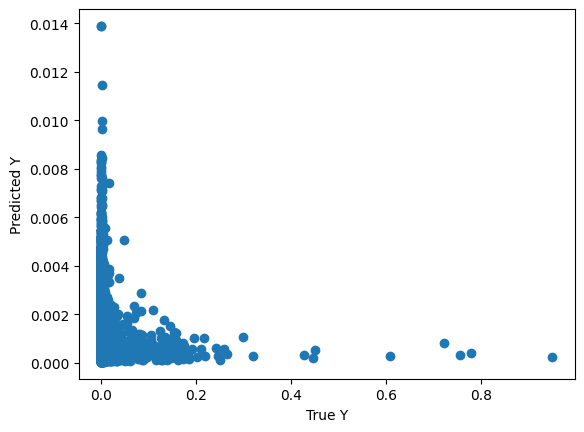

In [ ]:
# Evaluate
true_y = Y_torch_WT.detach().numpy()
pred_y = model(X_re).detach().numpy()
print(pred_y.shape)
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.scatter(true_y, pred_y)
plt.xlabel('True Y')
plt.ylabel('Predicted Y')

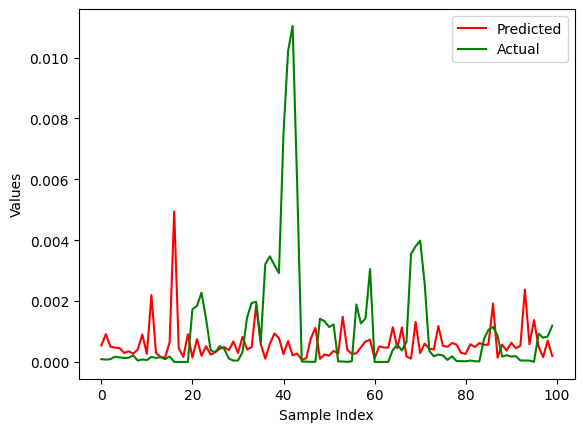

In [ ]:
to_num = 100

plt.plot(range(to_num), pred_y[:to_num], color="red", label="Predicted")
plt.plot(range(to_num), true_y[:to_num], color="green", label="Actual")

plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.legend()
plt.show()

In [ ]:
rmse_values = []
for i in range(len(pred_y)):
  rmse = np.sqrt(np.mean((pred_y[i] - true_y[i])**2))
  rmse_values.append(rmse)

# Create lists to store gene names and RMSE values
gene_names = []
rmse_list = []

for i, gene_name in enumerate(all_gene_names):
  gene_names.append(gene_name)
  rmse_list.append(rmse_values[i])


In [ ]:
import csv

gene_names_rmse = []

for i, gene_name in enumerate(all_gene_names):
  rmse = np.sqrt(np.mean((pred_y[i] - true_y[i])**2))
  gene_rmse = (gene_name, rmse)
  gene_names_rmse.append(gene_rmse)
with open('gene_rmse_with_WT.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['Gene Name', 'RMSE']) # Column headers
  for row in gene_names_rmse:
    writer.writerow(row) # Each row is a tuple

#RNN

#Modified LSTM

In [ ]:
import torch.nn as nn
from torch.autograd import Variable
class ImprovedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super(ImprovedLSTM, self).__init__()

        # Added L2 regularization
        self.reg_lambda = 0.01

        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Added dropout layer
        self.dropout = nn.Dropout(p=0.3)

        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Added dropout
        x = self.dropout(x)
        x = x.view(-1, self.seq_length, self.input_size)

        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        out = self.relu(out)  # Removed final activation for regression
        return out

In [ ]:
num_epochs = 150  # 1000 epochs
learning_rate = 0.0001 # 0.001 lr

input_size = X_torch_WT.shape[3]  # number of features ==5
hidden_size = 20  # number of features in hidden state
num_layers = 1  # number of stacked lstm layers

num_classes = 1  # number of output classes

seq_length = X_torch_WT.shape[1] #4


In [ ]:
print(input_size)

5


In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize the model with the appropriate arguments
lstm1 = ImprovedLSTM(input_size, hidden_size, num_layers, seq_length) #our lstm class
print(lstm1)

criterion = nn.MSELoss()

def loss_function(outputs, targets):
    loss = criterion(outputs, targets)
    l2_reg = 0

    for param in model.parameters():
        l2_reg += torch.norm(param)

    return loss + self.reg_lambda * l2_reg  # mean-squared error for regression

# Choose an optimizer (e.g., SGD or Adam)
optimizer = torch.optim.SGD(lstm1.parameters(), lr=0.001, momentum=0.9)

# Initialize the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

ImprovedLSTM(
  (lstm): LSTM(5, 20, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_1): Linear(in_features=20, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


#Training Loop

In [ ]:
print(X_torch_WT.shape)
print(Y_torch_WT.shape)

torch.Size([25706, 3, 3, 5])
torch.Size([102824, 1])


In [ ]:
from tqdm.notebook import tqdm

Y_torch_WT = Y_torch_WT[:77118]
for epoch in tqdm(range(num_epochs)):
    outputs = lstm1.forward(X_torch_WT) #forward pass

    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    # obtain the loss function

    # print (outputs.shape, Y_torch.shape)
    loss = criterion(outputs, Y_torch_WT)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop
    scheduler.step(loss)
    with torch.no_grad():
        if epoch % 5 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
            print("RMSE:", np.sqrt(loss.item()))

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 0, loss: 0.00871
RMSE: 0.09331493457197555
Epoch: 5, loss: 0.00769
RMSE: 0.08768748278169061
Epoch: 10, loss: 0.00580
RMSE: 0.07615117562086132
Epoch: 15, loss: 0.00388
RMSE: 0.062269775854747474
Epoch: 20, loss: 0.00234
RMSE: 0.04835344855241515
Epoch: 25, loss: 0.00129
RMSE: 0.03586203696150436
Epoch: 30, loss: 0.00065
RMSE: 0.025541986871280165
Epoch: 35, loss: 0.00032
RMSE: 0.017790665111005705
Epoch: 40, loss: 0.00016
RMSE: 0.012755758440746829
Epoch: 45, loss: 0.00011
RMSE: 0.0102595589729913
Epoch: 50, loss: 0.00009
RMSE: 0.009528049702788045
Epoch: 55, loss: 0.00009
RMSE: 0.009425151641214777
Epoch: 60, loss: 0.00009
RMSE: 0.009413695555154825
Epoch: 65, loss: 0.00009
RMSE: 0.009414624935875237
Epoch: 70, loss: 0.00009
RMSE: 0.009414236191526319
Epoch: 75, loss: 0.00009
RMSE: 0.00941557779399015
Epoch: 80, loss: 0.00009
RMSE: 0.00941404683707347
Epoch: 85, loss: 0.00009
RMSE: 0.00941524202490375
Epoch: 90, loss: 0.00009
RMSE: 0.009415243570473582
Epoch: 95, loss: 0.00009

[0.]


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


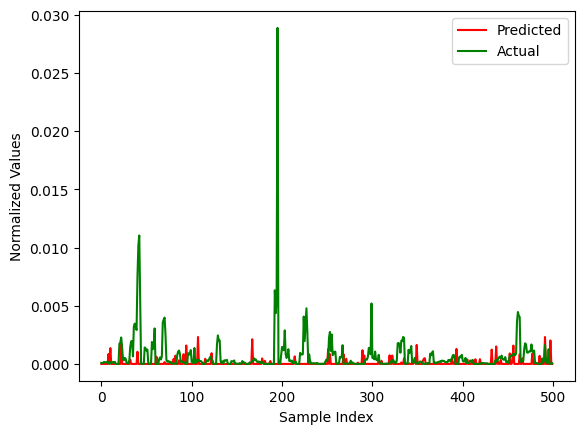

In [ ]:
# Import necessary libraries and functions
import torch.optim as optim
import torch.utils.data as data
from scipy.stats import zscore

# Define a function to calculate Z-scores for data
def get_z_score(df):
    mean = df.mean().mean()
    std = df.stack().std()
    return (df - mean) / std

# Define a function to normalize data
def normalize_data(df, exclude_cols=None):
    all_cols = list(df.columns)
    if exclude_cols:
        for col in exclude_cols:
            all_cols.remove(col)

    df[all_cols] = get_z_score(df[all_cols])
    min_ = df[all_cols].min().min()
    max_ = df[all_cols].max().max()
    df[all_cols] = (df[all_cols] - min_) / (max_ - min_)
    return df

# Define a function to normalize data along a specified axis
def normalize_data_axis(df, axis=1):
    MIN = df.min(axis)
    MAX = df.max(axis)
    return df.sub(MIN, 1 - axis).div(MAX - MIN, 1 - axis)

# Load and preprocess your data using these functions
filtered_all_lines_temp = filtered_all_lines[filtered_all_lines.columns[1:]]
std = filtered_all_lines_temp.stack().std()
mean = filtered_all_lines_temp.mean().mean()
Min = filtered_all_lines_temp.min().min()
Max = filtered_all_lines_temp.max().max()

predicted_values = []

with torch.no_grad():
    predicted_values = lstm1.forward(X_torch_WT)
    predicted_values = predicted_values.numpy()

predicted_values = predicted_values[:77118]

print(predicted_values[100])

# Normalize the predicted values
# normalized = predicted_values
# for i in range(len(normalized)):
#     normalized[i] = (normalized[i] - Min) / (Max - Min)

# Example of plotting using matplotlib
import matplotlib.pyplot as plt

to_num = 500
pred_pres = predicted_values[:to_num] #changed from normalized[:to_num]
x_coords = [i for i in range(to_num)]

actuals = []
for i in range(len(Y_torch_WT)):
    actuals.append(Y_torch_WT[i])

actuals = actuals[:to_num]

plt.plot(x_coords, pred_pres, color="red", label="Predicted")
plt.plot(x_coords, actuals, color="green", label="Actual")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Values")
plt.legend()
plt.show()


In [ ]:
# test to check values, with input data only

import matplotlib.pyplot as plt
# %matplotlib inline

sample = X[1]
predicted_values = []

with torch.no_grad():
    # for sample in X:
    predicted_values = lstm1.forward(torch.Tensor(X))
    predicted_values = predicted_values.numpy()
        # .data.numpy()
        # predicted_values.append(predicted_values)
# predicted_values= predicted_values.reshape(len(Y),).tolist()
print (len(predicted_values))

NameError: ignored

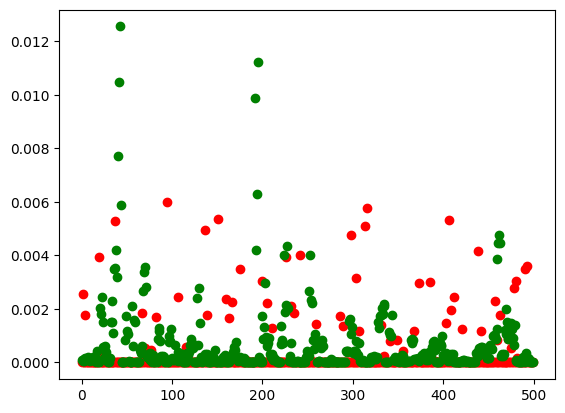

In [ ]:
to_num = 500

pred_pres = predicted_values[:to_num]
x_coords = [i for i in range(to_num)]
actual = Y_torch[:to_num]

plt.plot(x_coords, pred_pres, 'o', color = "red")
plt.plot(x_coords, actual , 'o', color = "green")
# plt.plot(len(Y), Y)


In [ ]:
gene_names_rmse = []

for i, gene_name in enumerate(all_gene_names):
  rmse = np.sqrt(np.mean((predicted_values[i] - Y_torch_WT[i].numpy())**2))
  gene_rmse = (gene_name, rmse)
  gene_names_rmse.append(gene_rmse)

# gene_names_rmse is now a list of tuples (gene_name, rmse)

In [ ]:
import csv

gene_names_rmse = []

for i, gene_name in enumerate(all_gene_names):
  rmse = np.sqrt(np.mean((predicted_values[i] - Y_torch_WT[i].numpy())**2))
  gene_rmse = (gene_name, rmse)
  gene_names_rmse.append(gene_rmse)

with open('gene_rmse_WT.csv', 'w') as f:
  writer = csv.writer(f)
  writer.writerow(['Gene Name', 'RMSE']) # Column headers
  for row in gene_names_rmse:
    writer.writerow(row) # Each row is a tuple

In [ ]:
import pandas as pd

# Load both CSV files into dataframes
df1 = pd.read_csv('gene_rmse_WT.csv')
df2 = pd.read_csv('gene_wo_elec_WT.csv')

# Merge dataframes on 'gene_name' column
merged_df = df1.merge(df2, on='Gene Name', suffixes=('_csv1', '_csv2'))

print(merged_df)

       Gene Name  RMSE_csv1  RMSE_csv2
0      AT1G01010   0.000092   0.000092
1      AT1G01020   0.000077   0.000077
2      AT1G01030   0.000091   0.000091
3      AT1G01040   0.000170   0.000170
4      AT1G01046   0.000148   0.000148
...          ...        ...        ...
25701  ATMG01370   0.000113   0.000113
25702  ATMG01380   0.000031   0.000128
25703  ATMG01390   0.000083   0.000083
25704  ATMG01400   0.000322   0.000322
25705  ATMG01410   0.000236   0.000236

[25706 rows x 3 columns]


In [ ]:
# Select rows where rmse_csv1 is lower than rmse_csv2
lower_rmse_genes = merged_df[merged_df['RMSE_csv1'] < merged_df['RMSE_csv2']]

# Extract the gene names where rmse_csv1 is lower than rmse_csv2
result_gene_names = lower_rmse_genes['Gene Name']


print("Gene names in csv1 with lower RMSE values than in csv2:")
print(result_gene_names)

Gene names in csv1 with lower RMSE values than in csv2:
32       AT1G01320
34       AT1G01350
37       AT1G01370
39       AT1G01390
69       AT1G01680
           ...    
25672    ATMG01020
25690    ATMG01230
25691    ATMG01250
25694    ATMG01275
25702    ATMG01380
Name: Gene Name, Length: 1677, dtype: object


In [ ]:
result_gene_names.to_csv('result_gene_names.csv', header=True, index=False)

# Step 2: Compare with "Ozone_responsive_genes" CSV file
# Read the "Ozone_responsive_genes" CSV file
ozone_genes_df = pd.read_csv('/content/OzoneResponsiveGenes.csv')

# Extract gene names in the "Locus" column of "Ozone_responsive_genes"
ozone_gene_names = ozone_genes_df['Locus']

# Compare the two sets of gene names and print matching gene names
matching_gene_names = result_gene_names[result_gene_names.isin(ozone_gene_names)]

print("Matching gene names in 'Ozone_responsive_genes':")
print(matching_gene_names)

Matching gene names in 'Ozone_responsive_genes':
2006     AT1G20630
3220     AT1G34420
4431     AT1G56650
5499     AT1G69450
7680     AT2G17420
8836     AT2G29500
12468    AT3G17700
13033    AT3G23400
14099    AT3G46230
15824    AT4G00290
16526    AT4G08920
17650    AT4G20380
17780    AT4G21870
17903    AT4G23100
20569    AT5G10490
21125    AT5G16470
21582    AT5G21100
22319    AT5G33280
24618    AT5G58940
25205    AT5G64940
25503    ATCG00120
25504    ATCG00130
Name: Gene Name, dtype: object


In [ ]:
file_path = '/content/OzoneResponsiveGenes.csv'  # Replace with the path to your CSV file
df = pd.read_csv(file_path)

# Step 3: Filter the DataFrame for matching gene names in the "Locus" column
filtered_df = df[df['Locus'].isin(matching_gene_names)]

# Step 4: Print the resulting DataFrame with all columns for matching gene names
print(filtered_df)

         Locus Gene Symbol                                          Full Name  \
18   AT4G23100        GSH1                          GLUTAMATE-CYSTEINE LIGASE   
30   AT3G23400        FIB4                                    FIBRILLIN 4FBN4   
63   AT5G33280        CLCG                                 CHLORIDE CHANNEL G   
124  AT1G69450     OSCA2.4  REDUCED HYPEROSMOLALITY-INDUCED CA2+ INCREASE 2.4   
141  ATCG00120        ATPA                         ATP SYNTHASE SUBUNIT ALPHA   
144  AT3G17700      CNGC20                  CYCLIC NUCLEOTIDE GATEDCHANNEL 20   
152  AT5G10490        MSL2                                        MSCS-LIKE 2   
165  ATCG00130        ATPF                                                NaN   
171  AT4G00290        MSL1                                                NaN   
193  AT5G64940        OSA1       OXIDATIVE STRESS-RELATED ABC1-LIKE PROTEIN 1   
218  AT3G46230     HSP17.4                            HEAT SHOCK PROTEIN 17.4   
223  AT1G56650       MYB75  

In [ ]:
filtered_df.to_csv('Result_WT_Line.csv', index=False)

# Print a message to confirm the save
print("Filtered DataFrame has been saved to 'filtered_file.csv'")

Filtered DataFrame has been saved to 'filtered_file.csv'
